In [17]:
import osmnx as ox
import networkx as nx
import pandas as pd
import geopandas as gpd
import shapely
import rasterio as rio
import libpysal
from shapely.geometry import Point, LineString, Polygon, MultiLineString
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np
import pycountry
from wpgpDownload.utils.wpcsv import Product
from wpgpDownload.utils.convenience_functions import refresh_csv
#refresh_csv()
from wpgpDownload.utils.convenience_functions import download_country_covariates as dl
import requests
from pyproj import CRS
import rasterstats
from rasterstats import zonal_stats
from shapely.validation import make_valid
import pysheds
from pysheds.grid import Grid
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from shapely import wkt
from shapely import ops
from shapely import geometry
from rasterio.plot import show_hist, show
import jenkspy
from jenkspy import JenksNaturalBreaks
from jenkspy import jenks_breaks
from shapely.geometry import mapping
from rasterio.features import rasterize
from scipy.ndimage import distance_transform_edt
from affine import Affine

# path for (temporary) downloads
download_path = 'C:/Users/Danny/Desktop/EMMA/IV/Data/'
# path of land cover raster >>> AUTOMATIZE LATER
lc_path = "C:/Users/Danny/Desktop/EMMA/IV/Data/Land_cover/ESA_WorldCover_10m_2021_v200_Nepal.tif"
# define study area according to OSM Nominatim (comma-seperated strings for
# several selection)s: https://nominatim.openstreetmap.org/ui/search.html
study_area = (["Myagdi, Nepal", "Baglung, Provinz Gandaki, Nepal", "Kushma, Nepal", "Jaljala, Nepal", "Thasang, Nepal", "Gharapjhong, Nepal"])
#study_area = (["Beni, Nepal", "Jaljala, Nepal"])
# "constrained": for official population counts or
# "UNadj_constrained" for UN adjusted population counts
population_type = ""

dem_path = 'C:/Users/Danny/Desktop/EMMA/IV/Data/DEM/ASTGTMV003_NEPAL.tif'
dem_proj_tif = 'C:/Users/Danny/Desktop/EMMA/IV/Data/DEM/ASTGTMV003_NEPAL_proj.tif'
dem_temp = 'C:/Users/Danny/Desktop/EMMA/IV/Data/DEM/ASTGTMV003_temporary.tif'

In [18]:
# %% >>> SOCIO-ECONOMIC IMPORTANCE
# fetch whole network for defined study area
network_graph = ox.graph_from_place(study_area,
                                    network_type="drive",
                                    buffer_dist=2000,
                                    clean_periphery=True)

# project the data
network_graph_proj = ox.project_graph(network_graph)
nodes_all, edges_all = ox.graph_to_gdfs(network_graph_proj,
                                        nodes=True,
                                        edges=True)
project_crs = nodes_all.crs

In [19]:
# Define the highway types to exclude
highway_types = ['motorway', 'trunk', 'primary']
# Filter edges_all for the defined types and all remaining
edges_study = edges_all[edges_all['highway'].isin(highway_types)]
edges_remaining = edges_all[~edges_all['highway'].isin(highway_types)]

In [20]:
# union all strings of edges_study  
edges_study_lines = []
edges_study_union = edges_study.unary_union
edges_study_union = shapely.ops.linemerge(edges_study_union)

d = {'geometry': [edges_study_union]}
edges_study_union = gpd.GeoDataFrame(d, crs=project_crs)

In [21]:
# create spatial weights matrix
W = libpysal.weights.Queen.from_dataframe(edges_remaining)
# get component labels
components = W.component_labels
edges_remaining = edges_remaining.dissolve(by=components)

C:\Users\Danny\AppData\Local\Programs\Python\Python310\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 46 disconnected components.
  warnings.warn(message)


In [22]:
# %% define cut-function
def cut(line, distance):
    # Cuts a line in two at a distance from its starting point
    if distance <= 0.0 or distance >= line.length:
        return [LineString(line)]
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(Point(p))
        if pd == distance:
            return [
                LineString(coords[:i + 1]),
                LineString(coords[i:])]
        if pd > distance:
            cp = line.interpolate(distance)
            return [
                LineString(coords[:i] + [(cp.x, cp.y)]),
                LineString([(cp.x, cp.y)] + coords[i:])]

def MultiCut(line, pieces):
    # define empty lists to append filtered lines and lines to cut
    lines_result = []
    lines_to_cut = []
    # ensure that there are at least two pieces
    if pieces == 1:  # result equals same line if one pieces
        lines_result.append(line)
    elif pieces == 2:  # cut line by middle point if two pieces
        distance = (line.length) / pieces
        lines_result.append(cut(line, distance)[0])
        lines_result.append(cut(line, distance)[1])
    else:  # cut line in number of pieces if more than three pieces
        # loop  from first to penultimate piece
        for i in range(1, pieces):
            # first piece is cut to save result and rest of line
            if i == 1:
                distance = (line.length) / pieces  # distance equals line lenght divided by number of pieces
                lines_result.append(cut(line, distance)[0])  # cut line and save first part in lines_result
                lines_to_cut = cut(line, distance)[1]  # save rest of line in lines_to_cut to continue with split

            # split line if pieces equal to pieces minus two; save only first part in lines_result
            # to continue with split
            if 1 < i <= pieces - 2:
                distance = (line.length) / pieces
                lines_result.append(cut(lines_to_cut, distance)[0])
                lines_to_cut = cut(lines_to_cut, distance)[1]

            # finally cut line if pieces  equal to pieces minus 1 and save both parts in lines_result
            if (i != 1) and (i == pieces - 1):
                distance = (line.length) / pieces
                lines_result.append(cut(lines_to_cut, distance)[0])
                lines_result.append(cut(lines_to_cut, distance)[1])

    return lines_result


edges_study_union = edges_study_union.reset_index()
edges_to_cut = edges_study_union.geometry

road_results = []
for j in range(0, len(edges_to_cut)):
    if edges_to_cut[j].length > 1000:
        line = edges_to_cut[j]
        pieces = int(((line.length) // 1000) + 1)
        road_results.append(list(MultiCut(line, pieces)))


edges_main = gpd.GeoDataFrame(np.concatenate(road_results))
edges_main.columns = ['geometry']
edges_main = edges_main.set_crs(project_crs)

In [23]:
# %%
# normalize centrality values to summarize them with population later to create quantiles
BC = nx.betweenness_centrality(nx.line_graph(network_graph_proj))  # weight="length")
edges_all['centrality'] = pd.DataFrame.from_dict(BC, orient='index')
edges_all['norm_centrality'] = (edges_all['centrality'] - edges_all['centrality'].min()) / (edges_all['centrality'].max() - edges_all['centrality'].min())  # not needed?
network_graph_proj = None

In [24]:
# sort the edges by length, in descending order
edges_all.sort_values(by='length', ascending=False, inplace=True)

# drop duplicate rows, keeping only the first occurrence of each length
edges_all = edges_all.drop_duplicates(subset=['length'], keep='first')

# separate the reversed edges and non-reversed edges
true_rev = edges_all[edges_all['reversed'] == True]
non_rev = edges_all[edges_all['reversed'] == False]

# concatenate the true_rev and non_rev dataframes
edges_all = pd.concat([true_rev, non_rev])

# round the length values to one decimal place
edges_all['length'] = edges_all['length'].round(1)
true_rev = None
non_rev = None

cols_to_drop = ['oneway', 'reversed', 'lanes', 'length', 'maxspeed']
edges_all.drop(cols_to_drop, axis=1, inplace=True)
edges_all = edges_all.reset_index(drop=True)

In [25]:
# %% buffer edges to extract population counts along the edge
edges_main_buffered = edges_main.buffer(50, cap_style=2)
edges_main_buffered = gpd.GeoDataFrame(geometry=gpd.GeoSeries(edges_main_buffered))

edges_remaining_buffered = edges_remaining.buffer(50, cap_style=2)
edges_remaining_buffered = gpd.GeoDataFrame(geometry=gpd.GeoSeries(edges_remaining_buffered))

In [26]:
# >>> population raster
# identify ISO country code to automatically download population raster based on OSM-input
if not download_path.endswith("/"):
    download_path = download_path + "/"

study_area_str = " ".join(study_area)
for country in pycountry.countries:
    if country.name in study_area_str:
        iso_code = country.alpha_3

# %%
products = Product(iso_code)  # Where instead of NPL it could be any valid ISO code.
#  to list all the products for NPL
# for p in products:
#    if "2020" in p.dataset_name:
#        print('%s/%s\t%s\t%s' % (p.idx, p.country_name,p.dataset_name,p.path))

prod_name_input = "ppp_2020" + population_type

#dl(ISO=iso_code, out_folder=download_path, prod_name=prod_name_input)

In [27]:
# %% define boundaries to mask raster
aoi = ox.geocode_to_gdf(study_area)
aoi = aoi.dissolve()
aoi = aoi.to_crs(project_crs)
aoi['geometry'] = aoi.geometry.buffer(2000)
aoi_flooding = gpd.GeoDataFrame()
aoi_flooding['geometry'] = aoi.geometry.buffer(10000)
aoi_file = download_path + "aoi.shp"

xmin, ymin, xmax, ymax = aoi_flooding.total_bounds
polygon = Polygon([[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]])

bbox = gpd.GeoDataFrame(crs=project_crs, geometry=[polygon])
aoi.to_file(aoi_file)
aoi_flooding.to_file('flooding_bound.shp')

C:\Users\Danny\AppData\Local\Temp\ipykernel_8836\3604115111.py:14: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  aoi.to_file(aoi_file)


In [28]:
# %% open downloaded raster, reproject, and mask with aoi boundary
raster_crs = CRS(project_crs).to_epsg()
mask_coords = bbox['geometry']
file_name = iso_code + "_" + prod_name_input + ".tif"
file_name = file_name.lower()
pop_path = download_path + file_name
file_substr = ".tif"
pop_idx = pop_path.index(file_substr)
pop_proj_tif = pop_path[:pop_idx] + "_reproj" + pop_path[pop_idx:]
pop_proj_clip_tif = pop_proj_tif[:pop_idx] + "_clipped" + pop_proj_tif[pop_idx:]

In [13]:
with rio.open(pop_path, mode='r+') as pop:
    pop.nodata = 0
    transform, width, height = calculate_default_transform(
        pop.crs, raster_crs, pop.width, pop.height, *pop.bounds)
    kwargs = pop.meta.copy()
    kwargs.update({
        'crs': raster_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rio.open(pop_proj_tif, 'w', **kwargs) as pop_proj:
        pop_proj.nodata = 0
        for i in range(1, pop.count + 1):
            reproject(
                source=rio.band(pop, i),
                destination=rio.band(pop_proj, i),
                resampling=Resampling.nearest)
            pop_proj.close()
pop = None

In [14]:
with rio.open(pop_proj_tif) as pop_proj:
    pop_out_image, out_transform = rio.mask.mask(pop_proj, aoi.geometry, crop=True)
    pop_out_meta = pop_proj.meta

pop_out_meta.update({"driver": "GTiff",
                     "height": pop_out_image.shape[1],
                     "width": pop_out_image.shape[2],
                     "transform": out_transform})

with rio.open(pop_proj_clip_tif, "w", **pop_out_meta) as pop_dest:
    pop_dest.nodata = 0
    pop_dest.write(pop_out_image)
pop_proj = None
pop_dest = None
pop_out_image = None

In [15]:
# %% read clipped population raster and assign values to numpy nd array
pop_raster = rio.open(pop_proj_clip_tif)
pop_count_array = pop_raster.read(1)
affine = pop_raster.transform

In [16]:
# %% calculating zonal statistics
main_pop_means = rasterstats.zonal_stats(edges_main_buffered, pop_count_array,
                                         affine=affine,
                                         nodata=np.nan,
                                         stats=['mean'],
                                         geojson_out=True)

# extract average population data from list
main_pop_mean_list = []
i = 0

while i < len(main_pop_means):
    main_pop_mean_list.append(main_pop_means[i]['properties'])
    i = i + 1

In [17]:
# %% create df and assign scores based on quantiles ## get NaN values if not converting index
main_pop_mean = pd.DataFrame(main_pop_mean_list)
main_pop_mean = main_pop_mean.set_index(edges_main_buffered.index)
edges_main_buffered['road_pop'] = main_pop_mean['mean']

In [18]:
# %% calculating zonal statistics
rem_pop_sums = rasterstats.zonal_stats(edges_remaining_buffered, pop_count_array,
                                        affine=affine,
                                        nodata=np.nan,
                                        stats=['sum'],
                                        geojson_out=True)

# extract average population data from list
rem_pop_sum_list = []
i = 0

while i < len(rem_pop_sums):
    rem_pop_sum_list.append(rem_pop_sums[i]['properties'])
    i = i + 1
pop_count_array = None

In [19]:
# %% create df and assign scores based on quantiles ## get NaN values if not converting index
rem_pop_sum = pd.DataFrame(rem_pop_sum_list)
rem_pop_sum = rem_pop_sum.set_index(edges_remaining_buffered.index)
edges_remaining_buffered['int_pop'] = rem_pop_sum['sum']

#buffered_pop = gpd.sjoin(edges_main, edges_main_buffered, how="left", predicate="within")
edges_remaining_buffered = gpd.sjoin(edges_remaining_buffered, edges_remaining, how="inner", predicate="intersects")
edges_remaining_buffered.drop('index_right', axis=1, inplace=True)
buffer_nodes = nodes_all.buffer(2)
buffer_nodes = gpd.GeoDataFrame(geometry=gpd.GeoSeries(buffer_nodes))

In [20]:
# %%
pop_nodes = gpd.sjoin(nodes_all, edges_remaining_buffered, how="inner", predicate="intersects")  # <___use rem_buffered_pop instead?
pop_nodes.drop('index_right',
               axis=1, inplace=True)

In [21]:
# %%
# create spatial weights matrix
W = libpysal.weights.Queen.from_dataframe(edges_all)
# get component labels
components = W.component_labels
all_roads_shape = edges_all.dissolve(by=components)

all_roads_shape.drop(all_roads_shape.columns.difference(['geometry']), 1, inplace=True)

C:\Users\Danny\AppData\Local\Programs\Python\Python310\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 30 disconnected components.
 There is 1 island with id: 1972.
  warnings.warn(message)
C:\Users\Danny\AppData\Local\Temp\ipykernel_14284\1004469085.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  all_roads_shape.drop(all_roads_shape.columns.difference(['geometry']), 1, inplace=True)


In [22]:
# %%
cut_network = gpd.sjoin(edges_main, all_roads_shape, how="left", predicate="intersects")
cut_network['ID'] = cut_network.index + 1
#buffered_pop = buffered_pop.reset_index(drop=True)
cut_network = cut_network.reset_index(drop=True)

cut_network.drop(['index_right'],
                 axis=1, inplace=True)

In [23]:
#%%
# calculate population along the road/1000m
cut_network['road_pop'] = edges_main_buffered['road_pop']
cut_network = gpd.sjoin(cut_network, edges_all, how="left", predicate="intersects")
cut_network['length'] = cut_network.length
cut_network['road_pop'] = cut_network['road_pop'] / cut_network['length'] * 1000
edges_all = None

In [26]:
#%%
cut_network = cut_network.drop_duplicates(subset=['ID'], keep="first")

cut_network['highway'] = cut_network['highway'].astype(str)
cut_network['osmid'] = cut_network['osmid'].astype(str)
cut_network['name'] = cut_network['name'].astype(str)


'''# Create a custom function for defining the label based on the si_quantile value
def population_label(value):
    if value <= 1:
        return 1
    elif value > 1 and value <= 7:
        return 2
    elif value > 7 and value <= 14:
        return 3
    elif value > 14 and value <= 28:
        return 4
    elif value > 28:
        return 5

# Apply the custom_label function to the si_quantile column
cut_network['si_score'] = cut_network['road_pop'].apply(population_label)'''

# Compute Jenks natural breaks
breaks = jenks_breaks(cut_network['road_pop'], n_classes=5)
# Cut cut_network['road_pop'] based on the breaks
cut_network['si_score'] = np.digitize(cut_network['road_pop'], bins=breaks, right=True)

In [50]:
# %%
lc_idx = lc_path.index(file_substr)
lc_proj_tif = lc_path[:lc_idx] + "_reproj" + lc_path[lc_idx:]
lc_proj_clip_tif = lc_proj_tif[:lc_idx] + "_clipped" + lc_proj_tif[lc_idx:]

In [31]:
'''# Open the original raster
with rio.open(lc_path) as src:

    # Get the existing transform and width/height
    transform, width, height = calculate_default_transform(src.crs, src.crs, src.width, src.height, *src.bounds)

    # Modify the existing transform to match the new resolution
    pixel_size = dem_out_meta['transform'][0]
    transform = Affine(pixel_size, 0, src.bounds.left, 0, -pixel_size, src.bounds.top)

    # Calculate the new width and height based on the new resolution
    new_width = int(np.ceil((src.bounds.right - src.bounds.left) / pixel_size))
    new_height = int(np.ceil((src.bounds.top - src.bounds.bottom) / pixel_size))

    # Create a metadata dictionary for the resampled raster
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': src.crs,
        'transform': transform,
        'width': new_width,
        'height': new_height
    })

    # Write the resampled raster to a new file
    with rio.open(lc_proj_tif, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(source=rio.band(src, i), destination=rio.band(dst, i), resampling=Resampling.nearest)'''

"# Open the original raster\nwith rio.open(lc_path) as src:\n\n    # Get the existing transform and width/height\n    transform, width, height = calculate_default_transform(src.crs, src.crs, src.width, src.height, *src.bounds)\n\n    # Modify the existing transform to match the new resolution\n    pixel_size = dem_out_meta['transform'][0]\n    transform = Affine(pixel_size, 0, src.bounds.left, 0, -pixel_size, src.bounds.top)\n\n    # Calculate the new width and height based on the new resolution\n    new_width = int(np.ceil((src.bounds.right - src.bounds.left) / pixel_size))\n    new_height = int(np.ceil((src.bounds.top - src.bounds.bottom) / pixel_size))\n\n    # Create a metadata dictionary for the resampled raster\n    kwargs = src.meta.copy()\n    kwargs.update({\n        'crs': src.crs,\n        'transform': transform,\n        'width': new_width,\n        'height': new_height\n    })\n\n    # Write the resampled raster to a new file\n    with rio.open(lc_proj_tif, 'w', **kwargs) 

In [32]:
'''# Open the input raster file
with rio.open(lc_proj_tif) as landcover:
    # Reproject to desired CRS
    transform, width, height = calculate_default_transform(
        landcover.crs, raster_crs, landcover.width, landcover.height, *landcover.bounds)
    kwargs = landcover.meta.copy()
    kwargs.update({
        'crs': raster_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    with rio.open(lc_proj_tif, 'w', **kwargs) as landcover_proj:
        landcover_proj.nodata = 0
        for i in range(1, landcover.count + 1):
            reproject(
                source=rio.band(landcover, i),
                destination=rio.band(landcover_proj, i),
                resampling=Resampling.nearest)

# Clip the reprojected raster
with rio.open(lc_proj_tif) as landcover_proj:
    landcover_clip, clip_transform = mask(landcover_proj, bbox.geometry, crop=True)
    landcover_clip_meta = landcover_proj.meta
    landcover_clip_meta.update({
        "height": landcover_clip.shape[1],
        "width": landcover_clip.shape[2],
        "transform": clip_transform
    })
    with rio.open(lc_proj_clip_tif, "w", **landcover_clip_meta) as landcover_dest:
        landcover_dest.nodata = 0
        landcover_dest.write(landcover_clip)'''

'''# Resample the clipped raster
with rio.open(lc_proj_clip_tif) as landcover_resample:
    data = landcover_resample.read(
        out_shape=(landcover_resample.count, int(height / 2), int(width / 2)),
        resampling=Resampling.bilinear)
    kwargs = landcover_resample.meta.copy()
    kwargs.update({
        'height': int(height / 2),
        'width': int(width / 2),
        'transform': rio.windows.transform(landcover_resample.bounds, int(height / 2), int(width / 2))
    })
    with rio.open(lc_resample_tif, 'w', **kwargs) as landcover_resampled:
        landcover_resampled.nodata = 0
        landcover_resampled.write(data)''''''

SyntaxError: incomplete input (823704698.py, line 47)

In [ ]:
'''with rio.open(lc_path, mode='r+') as landcover:
    landcover.nodata = 0
    transform, width, height = calculate_default_transform(
        landcover.crs, raster_crs, landcover.width, landcover.height, *landcover.bounds)
    kwargs = landcover.meta.copy()
    kwargs.update({
        'crs': raster_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rio.open(lc_proj_tif, 'w', **kwargs) as landcover_proj:
        landcover_proj.nodata = 0
        for i in range(1, landcover.count + 1):
            reproject(
                source=rio.band(landcover, i),
                destination=rio.band(landcover_proj, i),
                resampling=Resampling.nearest)
landcover = None'''

In [51]:
with rio.open(lc_proj_tif) as landcover_proj:
    landcover_out_image, out_transform = rio.mask.mask(landcover_proj, aoi_flooding.geometry, crop=True)
    landcover_out_meta = landcover_proj.meta

landcover_out_meta.update({"driver": "GTiff",
                     "height": landcover_out_image.shape[1],
                     "width": landcover_out_image.shape[2],
                     "transform": out_transform})

with rio.open(lc_proj_clip_tif, "w", **landcover_out_meta) as landcover_dest:
    landcover_dest.nodata = 0
    landcover_dest.write(landcover_out_image)
landcover_proj = None
landcover_dest = None
landcover_out_image = None

In [ ]:
'''lc_raster = rio.open(lc_proj_clip_tif)
lc_array = lc_raster.read(1)
lc_affine = lc_raster.transform

# %% calculating zonal statistics
landcover_majority = rasterstats.zonal_stats(edges_main_buffered, lc_array,
                                         affine=lc_affine,
                                         nodata=255,
                                         stats=['majority'],
                                         geojson_out=True)

# extract average population data from list
landcover_majority_list = []
i = 0

while i < len(landcover_majority):
    landcover_majority_list.append(landcover_majority[i]['properties'])
    i = i + 1'''

In [33]:
# Read the raster data
with rio.open(lc_proj_clip_tif) as src:
    raster_data = src.read(1)
    affine = src.transform

edges_main_buffered['lc_major'] = zonal_stats(edges_main_buffered, 
                             raster_data, 
                             stats="majority", # any other stat will also do
                             categorical=True,
                             nodata=-999,
                             affine=affine)

for i, feature in edges_main_buffered.iterrows():
    lc_dict = feature['lc_major']
    lc_sum = sum(lc_dict.values())

pixel_sums = [sum(feature_stats.values()) for feature_stats in edges_main_buffered['lc_major']]
edges_main_buffered['pixel_sum'] = pixel_sums

In [34]:
# Count pixels for land cover classes 40 and 50
lc_classes = [40, 50]
for lc_class in lc_classes:
    col_name = f'lc_{lc_class}_count'
    lc_counts = []
    for lc_dict in edges_main_buffered['lc_major']:
        if lc_class in lc_dict:
            lc_counts.append(lc_dict[lc_class])
        else:
            lc_counts.append(0)
    edges_main_buffered[col_name] = lc_counts

edges_main_buffered['lc_40_prop'] = edges_main_buffered['lc_40_count'] / edges_main_buffered['pixel_sum']
edges_main_buffered['lc_50_prop'] = edges_main_buffered['lc_50_count'] / edges_main_buffered['pixel_sum']

In [35]:
cut_network['lc40'] = edges_main_buffered['lc_40_prop']
cut_network['lc50'] = edges_main_buffered['lc_50_prop']

def assign_lc_weights(x):
    if x > 0.25:
        return 1
    else:
        return 0

cut_network['lc40_weight'] = cut_network['lc40'].apply(assign_lc_weights)
cut_network['lc50_weight'] = cut_network['lc50'].apply(assign_lc_weights)
cut_network['lc40_score'] = cut_network['lc40_weight'] * 0.2
cut_network['lc50_score'] = cut_network['lc50_weight'] * 0.5

In [58]:
#cut_network['li_value'] = np.where(cut_network['landcover'] == 50, 0.5, 
#                          np.where(cut_network['landcover'] == 40, 0.2, 0))

def assign_pop_node_weights(x):
    if x > 5000:
        return 1
    elif x > 1000:
        return 0.8
    elif x > 200:
        return 0.6
    elif x > 50:
        return 0.4
    elif x > 1:
        return 0.2
    else:
        return 0


# Reset the index of the GeoDataFrames
pop_nodes = pop_nodes.reset_index(drop=True)
cut_network.drop(['index_right'],
                 axis=1, inplace=True)
cut_network = cut_network.reset_index(drop=True)

# Perform a spatial join between the GeoDataFrames
node_net = gpd.sjoin(pop_nodes, cut_network, how='inner', op='intersects')

# Group by the index of the cut_network feature and get the maximum 'int_pop' value
grouped = node_net.groupby(node_net.index_right)['int_pop'].max()

# Map the 'grouped' values to the 'node_pop' column of 'cut_network'
cut_network['node_pop'] = cut_network.index.map(grouped).fillna(0)
cut_network['node_pop_weight'] = cut_network['node_pop'].apply(assign_pop_node_weights)
# Cut cut_network['road_pop'] based on the breaks
cut_network['node_pop_score'] = cut_network['node_pop_weight'] * 0.5
cut_network['li_value'] = cut_network['lc40_score'] + cut_network['lc50_score'] + cut_network['node_pop_score']

C:\Users\Danny\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [60]:
evaluation_bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
evaluation_labels = [1, 2, 3, 4, 5]

#cut_network['li_value'].fillna(0, inplace=True)
cut_network['li_score'] = pd.cut(cut_network['li_value'], bins=evaluation_bins,
                            labels=evaluation_labels, include_lowest=True, right=True).astype(int)

cut_network['socioeconomic_score'] = (cut_network['li_score'] * 0.7) + (cut_network['si_score'] * 0.3)

In [61]:
cut_network['osmid'] = cut_network['osmid'].astype(str)
cut_network['name'] = cut_network['name'].astype(str)
cut_network['ref'] = cut_network['ref'].astype(str)
cut_network = cut_network.drop_duplicates(subset=['ID'], keep="first")
cut_network.to_file('C:/Users/Danny/Desktop/EMMA/IV/Data/Land_cover/correct/cut_network.shp')

C:\Users\Danny\AppData\Local\Temp\ipykernel_14284\954151583.py:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  cut_network.to_file('C:/Users/Danny/Desktop/EMMA/IV/Data/Land_cover/correct/cut_network.shp')


In [62]:
edges_main_buffered['socioeconomic_score'] = cut_network['socioeconomic_score']
edges_main_buffered['li_score'] = cut_network['li_score']
edges_main_buffered['si_score'] = cut_network['si_score']

In [63]:
edges_main_buffered.to_file('C:/Users/Danny/Desktop/EMMA/IV/Data/Land_cover/correct/edges_main_buffered.shp')


C:\Users\Danny\AppData\Local\Temp\ipykernel_14284\4206053645.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  edges_main_buffered.to_file('C:/Users/Danny/Desktop/EMMA/IV/Data/Land_cover/correct/edges_main_buffered.shp')


In [29]:
#%%
with rio.open(dem_path, mode='r+') as dem:
    dem.nodata = 0
    transform, width, height = calculate_default_transform(
        dem.crs, raster_crs, dem.width, dem.height, *dem.bounds)
    kwargs = dem.meta.copy()
    kwargs.update({
        'crs': raster_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rio.open(dem_proj_tif, 'w', **kwargs) as dem_proj:
        dem_proj.nodata = 0
        for i in range(1, dem.count + 1):
            reproject(
                source=rio.band(dem, i),
                destination=rio.band(dem_proj, i),
                resampling=Resampling.nearest)

In [30]:
with rio.open(dem_proj_tif) as dem_proj:
    dem_out_image, out_transform = rio.mask.mask(dem_proj, bbox.geometry, crop=True)
    dem_out_meta = dem_proj.meta
    pixel_size = abs(transform.a)
dem_out_meta.update({"driver": "GTiff",
                     "height": dem_out_image.shape[1],
                     "width": dem_out_image.shape[2],
                     "transform": out_transform})

with rio.open(dem_temp, "w", **dem_out_meta) as dem_dest:
    dem_dest.nodata = 0
    dem_dest.write(dem_out_image)

In [31]:
dem_temp_aoi = ('dem.tif')

with rio.open(dem_proj_tif) as dem_proj:
    dem_out_image, out_transform = rio.mask.mask(dem_proj, aoi_flooding.geometry, crop=True)
    dem_out_meta = dem_proj.meta
    pixel_size = abs(transform.a)
dem_out_meta.update({"driver": "GTiff",
                     "height": dem_out_image.shape[1],
                     "width": dem_out_image.shape[2],
                     "transform": out_transform})

with rio.open(dem_temp_aoi, "w", **dem_out_meta) as dem_dest:
    dem_dest.nodata = 0
    dem_dest.write(dem_out_image)

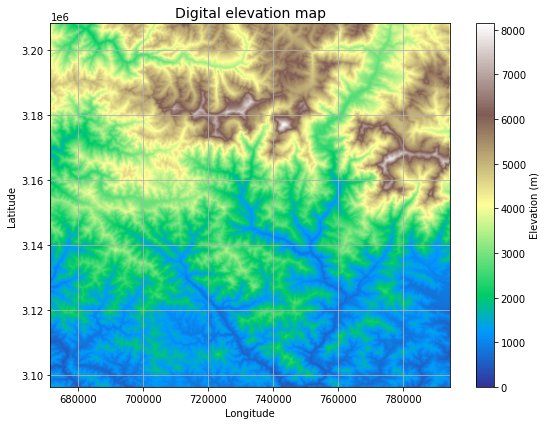

In [32]:
grid = Grid.from_raster(dem_temp, data_name='dem')
dem = grid.read_raster(dem_temp).astype(np.int16)

fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)

plt.imshow(dem, extent=grid.extent, cmap='terrain', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

In [33]:
# Condition DEM
# ----------------------
# Fill pits in DEM
pit_filled_dem = grid.fill_pits(dem)
# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)
# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)

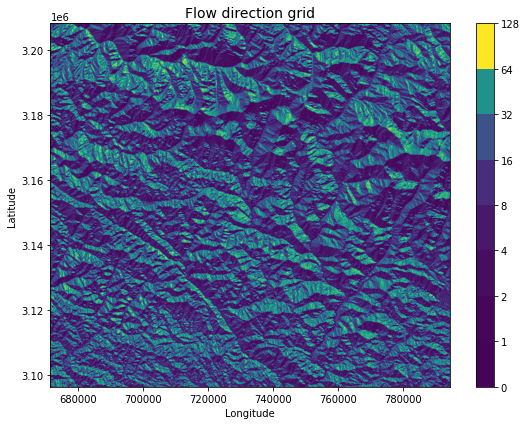

In [34]:
# Determine D8 flow directions from DEM
# ----------------------
# Specify directional mapping
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

# Compute flow directions
# -------------------------------------
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

fig = plt.figure(figsize=(8, 6))
fig.patch.set_alpha(0)

plt.imshow(fdir, extent=grid.extent, cmap='viridis', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries=boundaries,
             values=sorted(dirmap))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow direction grid', size=14)
plt.grid(zorder=-1)
plt.tight_layout()

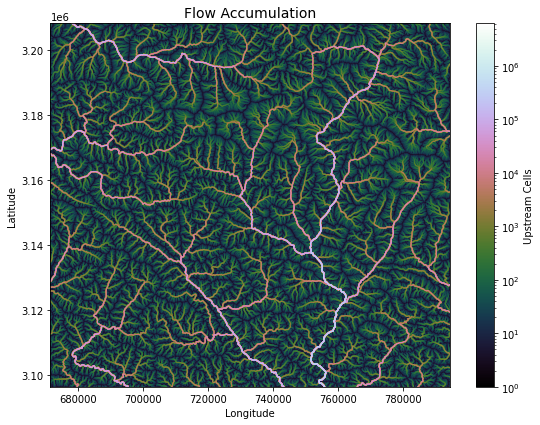

In [35]:
# Calculate flow accumulation and write raster to disk
# --------------------------
acc = grid.accumulation(fdir, dirmap=dirmap)

grid.to_raster(acc, 'flow_acc.tif', target_view=fdir.viewfinder,
               blockxsize=16, blockysize=16)

fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

NameError: name 'cut_network' is not defined

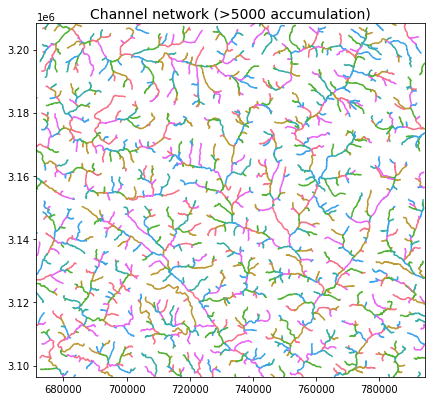

In [36]:
# Extract river network
branches = grid.extract_river_network(fdir, acc > 5000)

sns.set_palette('husl')
fig, ax = plt.subplots(figsize=(8.5, 6.5))

plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
ax.set_aspect('equal')

for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])

_ = plt.title('Channel network (>5000 accumulation)', size=14)

branches_gdf = gpd.GeoDataFrame.from_features(branches, crs=project_crs)
branches_gdf.to_file('branches.shp')

# %%
cut_network['drainage_pt'] = cut_network.intersection(branches_gdf.unary_union)
cut_network['drainage_area'] = cut_network['drainage_pt']
cut_network['drainage_area'] = cut_network['drainage_area']
#cut_network['drainage_area'] = wkt.dumps(cut_network['drainage_area'])
cut_network['drainage_area'] = cut_network.drainage_area.apply(lambda x: wkt.dumps(x))

In [ ]:
def slope_gradient(elev, cellsize):
    px, py = np.gradient(elev, cellsize)
    slope_percent = np.sqrt(px ** 2 + py ** 2)
    # convert percentage to degrees
    slope_deg = np.degrees(np.arctan(slope_percent))
    return slope_deg

def catch_slope_score(x):
    if x < 10:
        return 1
    if 10 <= x < 20:
        return 2
    if 20 <= x < 30:
        return 3
    if 30 <= x < 40:
        return 4
    if x >= 40:
        return 5

def catch_area_score(x):
    if x < 50:
        return 1
    if 50 <= x < 100:
        return 2
    if 100 <= x < 500:
        return 3
    if 500 <= x < 1000:
        return 4
    if x >= 1000:
        return 5

In [133]:
catchment_area = []
catchment_slope = []
catchment_gdf = gpd.GeoDataFrame(geometry=[])

for row in cut_network.drainage_area:
    if "EMPTY" in row:
        # Handle empty catchment area
        catchment_area.append('0')
        catchment_slope.append('0')
    elif "MULTI" not in row:
        # Handle single catchment area
        grid = Grid.from_raster(dem_temp)   # remove at the end
        dem = grid.read_raster(dem_temp)    # remove at the end
        temp = row.split(" ",1)[1]
        x, y = map(str, temp.strip('()').split(' '))
        x_snap, y_snap = grid.snap_to_mask(acc > 200, (x, y))

        # Delineate the catchment
        catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, xytype='coordinate')
        catch = grid.view(catch, dtype=np.uint8)

        # Plot the result
        grid.clip_to(catch)
        catch_view = grid.view(catch)

        # Create a vector representation of the catchment mask
        shapes = grid.polygonize(catch_view)
        catchment_polygon = ops.unary_union([geometry.shape(shape)
                                     for shape, value in shapes])
        catchment_area.append(catchment_polygon.area)

        # grid.clip_to(catch)
        dem_view = grid.view(dem)
        slope_deg = slope_gradient(dem_view, 30)
        mean_slope = np.mean(slope_deg)  #[slope_deg != 0])
        mean_slope = str(mean_slope).strip('()')
        catchment_slope.append(mean_slope)

        # Append catchment polygon to catchment_gdf
        catchment_gdf = catchment_gdf.append({'geometry': catchment_polygon, 'catchment_area': catchment_polygon.area, 'catchment_slope': mean_slope}, ignore_index=True)

    elif "MULTI" in row:
        # Handle multiple catchment areas
        multi_temp = row.split(" ", 1)[1]
        multi_list = multi_temp.strip('()').split(",")
        gdf = gpd.GeoDataFrame()
        for i in multi_list:
            grid = Grid.from_raster(dem_temp)   # remove at the end
            dem = grid.read_raster(dem_temp)    # remove at the end
            x, y = i.strip().split(' ')
            x_snap, y_snap = grid.snap_to_mask(acc > 200, (x, y))

            # Delineate the catchment
            catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, xytype='coordinate')
            catch = grid.view(catch, dtype=np.uint8)

            # Plot the result
            grid.clip_to(catch)
            catch_view = grid.view(catch)

            # Create a vector representation of the catchment mask
            shapes = grid.polygonize(catch_view)
            catchment_polygon = ops.unary_union([geometry.shape(shape)
                                        for shape, value in shapes])
            catch_gdf = gpd.GeoDataFrame({'geometry':[catchment_polygon]})
            #gdf = gdf.append(catch_gdf)
            gdf = pd.concat([gdf, catch_gdf])
            catchment_polygon = gdf.unary_union
            dem_view = grid.view(dem)
            slope_deg = slope_gradient(dem_view, 30)
            mean_slope = np.mean(slope_deg)  #[slope_deg != 0])
            mean_slope = str(mean_slope).strip('()')

            catchment_area.append(catchment_polygon.area)
            catchment_slope.append(mean_slope)
            # Append catchment polygon to catchment_gdf
            catchment_gdf = catchment_gdf.append({'geometry': catchment_polygon, 'catchment_area': catchment_polygon.area, 'catchment_slope': mean_slope}, ignore_index=True)

    else:
        catchment_area.append('Not_Rated')
        catchment_slope.append('Not_Rated')

catchment_gdf['catchment_area'] = catchment_gdf['catchment_area'] / 10000

C:\Users\Danny\AppData\Local\Temp\ipykernel_14284\2792935246.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  catchment_gdf = catchment_gdf.append({'geometry': catchment_polygon, 'catchment_area': catchment_polygon.area, 'catchment_slope': mean_slope}, ignore_index=True)
C:\Users\Danny\AppData\Local\Temp\ipykernel_14284\2792935246.py:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  catchment_gdf = catchment_gdf.append({'geometry': catchment_polygon, 'catchment_area': catchment_polygon.area, 'catchment_slope': mean_slope}, ignore_index=True)
C:\Users\Danny\AppData\Local\Temp\ipykernel_14284\2792935246.py:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  catchment_gdf = catchment_gdf.append({'geometry': catchment_polygon

C:\Users\Danny\AppData\Local\Temp\ipykernel_14284\2792935246.py:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  catchment_gdf = catchment_gdf.append({'geometry': catchment_polygon, 'catchment_area': catchment_polygon.area, 'catchment_slope': mean_slope}, ignore_index=True)
C:\Users\Danny\AppData\Local\Temp\ipykernel_14284\2792935246.py:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  catchment_gdf = catchment_gdf.append({'geometry': catchment_polygon, 'catchment_area': catchment_polygon.area, 'catchment_slope': mean_slope}, ignore_index=True)
C:\Users\Danny\AppData\Local\Temp\ipykernel_14284\2792935246.py:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  catchment_gdf = catchment_gdf.append({'geometry': catchment_polygon

C:\Users\Danny\AppData\Local\Temp\ipykernel_14284\2792935246.py:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  catchment_gdf = catchment_gdf.append({'geometry': catchment_polygon, 'catchment_area': catchment_polygon.area, 'catchment_slope': mean_slope}, ignore_index=True)
C:\Users\Danny\AppData\Local\Temp\ipykernel_14284\2792935246.py:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  catchment_gdf = catchment_gdf.append({'geometry': catchment_polygon, 'catchment_area': catchment_polygon.area, 'catchment_slope': mean_slope}, ignore_index=True)
C:\Users\Danny\AppData\Local\Temp\ipykernel_14284\2792935246.py:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  catchment_gdf = catchment_gdf.append({'geometry': catchment_polygon

C:\Users\Danny\AppData\Local\Temp\ipykernel_14284\2792935246.py:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  catchment_gdf = catchment_gdf.append({'geometry': catchment_polygon, 'catchment_area': catchment_polygon.area, 'catchment_slope': mean_slope}, ignore_index=True)
C:\Users\Danny\AppData\Local\Temp\ipykernel_14284\2792935246.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  catchment_gdf = catchment_gdf.append({'geometry': catchment_polygon, 'catchment_area': catchment_polygon.area, 'catchment_slope': mean_slope}, ignore_index=True)
C:\Users\Danny\AppData\Local\Temp\ipykernel_14284\2792935246.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  catchment_gdf = catchment_gdf.append({'geometry': catchment_polygon

C:\Users\Danny\AppData\Local\Temp\ipykernel_14284\2792935246.py:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  catchment_gdf = catchment_gdf.append({'geometry': catchment_polygon, 'catchment_area': catchment_polygon.area, 'catchment_slope': mean_slope}, ignore_index=True)
C:\Users\Danny\AppData\Local\Temp\ipykernel_14284\2792935246.py:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  catchment_gdf = catchment_gdf.append({'geometry': catchment_polygon, 'catchment_area': catchment_polygon.area, 'catchment_slope': mean_slope}, ignore_index=True)
C:\Users\Danny\AppData\Local\Temp\ipykernel_14284\2792935246.py:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  catchment_gdf = catchment_gdf.append({'geometry': catchment_polygon

C:\Users\Danny\AppData\Local\Temp\ipykernel_14284\2792935246.py:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  catchment_gdf = catchment_gdf.append({'geometry': catchment_polygon, 'catchment_area': catchment_polygon.area, 'catchment_slope': mean_slope}, ignore_index=True)
C:\Users\Danny\AppData\Local\Temp\ipykernel_14284\2792935246.py:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  catchment_gdf = catchment_gdf.append({'geometry': catchment_polygon, 'catchment_area': catchment_polygon.area, 'catchment_slope': mean_slope}, ignore_index=True)
C:\Users\Danny\AppData\Local\Temp\ipykernel_14284\2792935246.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  catchment_gdf = catchment_gdf.append({'geometry': catchment_polygon

In [153]:
catchment_gdf.crs = cut_network.crs
df_filtered = catchment_gdf[catchment_gdf['catchment_area'] < 10000]
pluvial_edge = gpd.sjoin(edges_main_buffered, df_filtered, how="right", predicate="intersects")

In [199]:
# Assuming your GeoDataFrame is called 'gdf'
grouped = pluvial_edge.groupby('index_left')

# Calculate new area for each group
new_area = grouped['catchment_area'].sum()

# Get the maximum value assigned to each group
max_value = grouped['catchment_slope'].max()

# Create new GeoDataFrame with the dissolved groups and the new columns
dissolved_gdf = gpd.GeoDataFrame(geometry=grouped.geometry.first(),
                                 data={'new_area': new_area,
                                       'max_value': max_value})


In [197]:
edges_main_buffered[['catchment_area', 'catchment_slope']] = dissolved_gdf[['new_area', 'max_value']].astype(float)
edges_main_buffered[['catchment_area', 'catchment_slope']] = edges_main_buffered[['catchment_area', 'catchment_slope']].fillna(0)
edges_main_buffered['area_score'] = edges_main_buffered['catchment_area'].apply(catch_area_score)
edges_main_buffered['slope_score'] = edges_main_buffered['catchment_slope'].apply(catch_slope_score)
edges_main_buffered['pluvial_score'] = (edges_main_buffered['area_score'] + edges_main_buffered['slope_score']) / 2

In [203]:
#pluvial_edge['osmid'] = pluvial_edge['osmid'].astype(str)
#pluvial_edge['reversed'] = pluvial_edge['reversed'].astype(str)
dissolved_gdf['max_value'] = dissolved_gdf['max_value'].astype(float)
dissolved_gdf.to_file('dissolved_gdf.shp')

In [201]:
dissolved_gdf
dissolved_gdf

,new_area,max_value,geometry
index_left,,,
0,4131.090382,18.62642874670838,"POLYGON ((762807.205 3138501.725, 762919.129 3..."
2,760.467002,18.155837962133056,"POLYGON ((764234.237 3130890.889, 764346.161 3..."
3,760.467002,18.155837962133056,"POLYGON ((764234.237 3130890.889, 764346.161 3..."
15,1817.432360,16.287138362973522,"POLYGON ((762751.243 3130695.021, 762835.186 3..."
16,1282.529595,16.287138362973522,"POLYGON ((762835.186 3130695.021, 762835.186 3..."
22,658.293684,21.731908263521,"POLYGON ((758022.451 3131786.281, 758078.413 3..."
26,1637.513368,22.529200313960388,"POLYGON ((757266.963 3135227.946, 757434.849 3..."
27,1637.513368,22.529200313960388,"POLYGON ((757266.963 3135227.946, 757434.849 3..."
30,2853.963054,19.712926948692704,"POLYGON ((754832.615 3140292.510, 754860.596 3..."


In [72]:
for col in pluvial_edge.columns:
    if pluvial_edge[col].dtype == 'object':
        if any(isinstance(val, list) for val in pluvial_edge[col]):
            print(f"The column '{col}' contains a list.")
        else:
            print(f"The column '{col}' does not contain a list.")

The column 'osmid' does not contain a list.
The column 'ref' does not contain a list.
The column 'highway' does not contain a list.
The column 'oneway' does not contain a list.
The column 'reversed' does not contain a list.
The column 'bridge' does not contain a list.
The column 'name' does not contain a list.
The column 'lanes' does not contain a list.
The column 'maxspeed' does not contain a list.
The column 'access' does not contain a list.
The column 'width' does not contain a list.
The column 'catchment_slope' does not contain a list.


In [54]:
clay_path = 'C:/Users/Danny/Desktop/EMMA/IV/Data/parentsoil/clay.tif'
sand_path = 'C:/Users/Danny/Desktop/EMMA/IV/Data/parentsoil/sand.tif'
scs_path = 'C:/Users/Danny/Desktop/EMMA/IV/Python_data/scs_classes.tif'

with rio.open(clay_path) as src_clay, rio.open(sand_path) as src_sand:
    clay = src_clay.read(1)
    sand = src_sand.read(1)

    group_a = (clay <= 20) & (sand > 50)
    group_b = (clay <= 25) & (sand <= 50)
    group_c = (clay > 20) & (clay <= 35) & (sand >= 45)
    group_d = (clay > 25) & (sand < 45) | (clay > 35)

    scs_classes = np.full(clay.shape, np.nan, dtype=np.float32)

    scs_classes[group_a] = 4
    scs_classes[group_b] = 6
    scs_classes[group_c] = 8
    scs_classes[group_d] = 10

# Store the profile before the datasets are closed
    profile = src_clay.profile

with rio.open(scs_path, 'w', **profile) as dst:
    dst.write(scs_classes, 1)

In [55]:
scs_proj_tif = 'C:/Users/Danny/Desktop/EMMA/IV/Python_data/scs_classes1.tif'
scs_temp = 'C:/Users/Danny/Desktop/EMMA/IV/Python_data/scs_classes2.tif'
scs_file_res = 'C:/Users/Danny/Desktop/EMMA/IV/Python_data/scs_classes3.tif'

with rio.open(scs_path, mode='r+') as scs:
    scs.nodata = 0
    transform, width, height = calculate_default_transform(
        scs.crs, raster_crs, scs.width, scs.height, *scs.bounds)
    kwargs = scs.meta.copy()
    kwargs.update({
        'crs': raster_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rio.open(scs_proj_tif, 'w', **kwargs) as scs_proj:
        scs_proj.nodata = 0
        for i in range(1, scs.count + 1):
            reproject(
                source=rio.band(scs, i),
                destination=rio.band(scs_proj, i),
                resampling=Resampling.nearest)

# Open the original raster
with rio.open(scs_proj_tif) as src:

    # Get the existing transform and width/height
    transform, width, height = calculate_default_transform(src.crs, src.crs, src.width, src.height, *src.bounds)

    # Modify the existing transform to match the new resolution
    pixel_size = dem_out_meta['transform'][0]
    transform = Affine(pixel_size, 0, src.bounds.left, 0, -pixel_size, src.bounds.top)

    # Calculate the new width and height based on the new resolution
    new_width = int(np.ceil((src.bounds.right - src.bounds.left) / pixel_size))
    new_height = int(np.ceil((src.bounds.top - src.bounds.bottom) / pixel_size))

    # Create a metadata dictionary for the resampled raster
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': src.crs,
        'transform': transform,
        'width': new_width,
        'height': new_height
    })

    # Write the resampled raster to a new file
    with rio.open(scs_temp, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(source=rio.band(src, i), destination=rio.band(dst, i), resampling=Resampling.nearest)

            
with rio.open(dem_temp_aoi) as target_raster:
    target_transform = target_raster.transform
    target_height, target_width = target_raster.shape
    
with rio.open(scs_temp) as scs_proj:
    scs_out_image, out_transform = rio.mask.mask(scs_proj, aoi_flooding.geometry, crop=True)
    scs_out_meta = scs_proj.meta
    pixel_size = abs(transform.a)

scs_out_meta.update({"driver": "GTiff",
                     "height": target_height,
                     "width": target_width,
                     "transform": target_transform})

with rio.open(scs_file_res, "w", **scs_out_meta) as scs_dest:
    scs_dest.nodata = 0
    scs_dest.write(scs_out_image)

In [56]:
slope_file = 'C:/Users/Danny/Desktop/EMMA/IV/Python_data/slope_classes.tif'

# Open the DEM raster
with rio.open(dem_temp_aoi) as src:
    # Read the raster into a NumPy array
    dem_data  = src.read(1)
    cellsize = src.res[0]

# Evaluate gradient in two dimensions
px, py = np.gradient(dem_data, cellsize)
slope = np.sqrt(px ** 2 + py ** 2)
#slope_percent = np.tan(slope) * 100

# If needed in degrees, convert using
slope_deg = np.degrees(np.arctan(slope))
slope_percent = np.tan(np.deg2rad(slope_deg)) * 100

# Initialize the new raster with NaN values
slope_classes = np.full(slope_percent.shape, np.nan, dtype=np.float32)

# Define the criteria for each group
group_a = (slope_percent >= 0) & (slope_percent <= 2)
group_b = (slope_percent > 2) & (slope_percent <= 5)
group_c = (slope_percent > 5) & (slope_percent <= 15)
group_d = (slope_percent > 15) & (slope_percent <= 35)
group_e = (slope_percent > 35)

# Assign values to the new raster based on the criteria
slope_classes[group_a] = 10
slope_classes[group_b] = 8
slope_classes[group_c] = 6
slope_classes[group_d] = 4
slope_classes[group_e] = 2

# Write the new raster to disk
with rio.open(
        slope_file,
        'w',
        driver='GTiff',
        width=slope_percent.shape[1],
        height=slope_percent.shape[0],
        count=1,
        dtype=rio.float32,
        crs=raster_crs,
        transform=src.transform
) as dst:
    dst.write(slope_classes.astype(rio.float32), 1)

In [57]:
# Write the new raster to disk
with rio.open(
        'slope_percent.tif',
        'w',
        driver='GTiff',
        width=slope_percent.shape[1],
        height=slope_percent.shape[0],
        count=1,
        dtype=rio.float32,
        crs=raster_crs,
        transform=src.transform
) as dst:
    dst.write(slope_percent.astype(rio.float32), 1)

In [58]:
flow_acc_file = 'C:/Users/Danny/Desktop/EMMA/IV/Python_data/flow_acc_classes.tif'

'''with rio.open(dem_temp_aoi) as dem:
    aoi = dem.read(1)
    aoi_transform = dem.transform

with rio.open('flow_acc.tif') as flow_acc:
    flow_acc_image, flow_acc_transform = rio.mask.mask(flow_acc, aoi, invert=False, transform=aoi_transform)
    flow_acc_meta = flow_acc.meta

flow_acc_meta.update({"driver": "GTiff",
                     "height": flow_acc_image.shape[1],
                     "width": flow_acc_image.shape[2],
                     "transform": flow_acc_transform})

with rio.open('flow_acc1.tif', "w", **flow_acc_meta) as flow_acc_dest:
    flow_acc_dest.nodata = 0
    flow_acc_dest.write(flow_acc_image)'''


# Open the flow accumulation raster
with rio.open('flow_acc.tif') as src:
    profile = src.profile
    flow_acc = src.read(1)
# Flatten the flow accumulation array
flow_acc_flat = flow_acc.ravel()

# Calculate the natural breaks using a sample of the data
sample_size = 10000
sample_idx = np.random.choice(flow_acc_flat.size, size=sample_size, replace=False)
breaks = jenks_breaks(flow_acc_flat[sample_idx], n_classes=4)

# Assign values to the new raster based on the natural breaks
flow_acc_classes = np.digitize(flow_acc, breaks, right=True) * 2

# Write the new raster to disk
with rio.open(flow_acc_file, 'w', **profile) as dst:
    dst.write(flow_acc_classes, 1)

In [59]:
dem_file = 'C:/Users/Danny/Desktop/EMMA/IV/Python_data/dem_classes.tif'

# Open the flow accumulation raster
with rio.open(dem_temp_aoi) as src:
    profile = src.profile
    dem = src.read(1)
# Flatten the flow accumulation array
dem_flat = dem.ravel()

# Calculate the natural breaks using a sample of the data
sample_size = 10000
sample_idx = np.random.choice(dem_flat.size, size=sample_size, replace=False)
breaks = jenks_breaks(dem_flat[sample_idx], n_classes=4)

# Assign values to the new raster based on the natural breaks and multiply by 2
dem_classes = np.digitize(dem, breaks, right=True) * 2

# Write the new raster to disk
with rio.open(dem_file, 'w', **profile) as dst:
    dst.write(dem_classes, 1)

In [60]:
prec_path = 'C:/Users/Danny/Desktop/EMMA/IV/Data/Precipitation/Annual_Precip/max_annual_precipitation.tif'
prec_proj_tif = 'C:/Users/Danny/Desktop/EMMA/IV/Data/Precipitation/Annual_Precip/max_annual_precipitation_proj.tif'
prec_temp = 'C:/Users/Danny/Desktop/EMMA/IV/Data/Precipitation/Annual_Precip/max_annual_precipitation_proj_clip.tif'
prec_file_res = 'C:/Users/Danny/Desktop/EMMA/IV/Python_data/precipitation_classes.tif'

with rio.open(prec_path, mode='r+') as prec:
    prec.nodata = 0
    transform, width, height = calculate_default_transform(
        prec.crs, raster_crs, prec.width, prec.height, *prec.bounds)
    kwargs = prec.meta.copy()
    kwargs.update({
        'crs': raster_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rio.open(prec_proj_tif, 'w', **kwargs) as prec_proj:
        prec_proj.nodata = 0
        for i in range(1, prec.count + 1):
            reproject(
                source=rio.band(prec, i),
                destination=rio.band(prec_proj, i),
                resampling=Resampling.nearest)


# Open the original raster
with rio.open(prec_proj_tif) as src:

    # Get the existing transform and width/height
    transform, width, height = calculate_default_transform(src.crs, src.crs, src.width, src.height, *src.bounds)

    # Modify the existing transform to match the new resolution
    pixel_size = dem_out_meta['transform'][0]
    transform = Affine(pixel_size, 0, src.bounds.left, 0, -pixel_size, src.bounds.top)

    # Calculate the new width and height based on the new resolution
    new_width = int(np.ceil((src.bounds.right - src.bounds.left) / pixel_size))
    new_height = int(np.ceil((src.bounds.top - src.bounds.bottom) / pixel_size))

    # Create a metadata dictionary for the resampled raster
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': src.crs,
        'transform': transform,
        'width': new_width,
        'height': new_height
    })

    # Write the resampled raster to a new file
    with rio.open(prec_temp, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(source=rio.band(src, i), destination=rio.band(dst, i), resampling=Resampling.nearest)
            

with rio.open(prec_temp) as prec_proj:
    prec_out_image, out_transform = rio.mask.mask(prec_proj, aoi_flooding.geometry, crop=True)
    prec_out_meta = prec_proj.meta
    pixel_size = abs(transform.a)
prec_out_meta.update({"driver": "GTiff",
                     "height": prec_out_image.shape[1],
                     "width": prec_out_image.shape[2],
                     "transform": out_transform})

with rio.open(prec_file_res, "w", **prec_out_meta) as prec_dest:
    prec_dest.nodata = 0
    prec_dest.write(prec_out_image)

In [61]:
precipitation_file = 'C:/Users/Danny/Desktop/EMMA/IV/Python_data/precipitation_classes.tif'

# Open the reprojected prec raster and clip by the clipping shapefile
with rio.open(prec_file_res) as src_prec:
    profile = src_prec.profile
    prec = src_prec.read(1)

# Flatten the prec array
prec_flat = prec.ravel()

# Calculate the natural breaks using a sample of the data
sample_size = 10000
sample_idx = np.random.choice(prec_flat.size, size=sample_size, replace=False)
breaks = jenks_breaks(prec_flat[sample_idx], n_classes=5)

# Assign values to the new raster based on the natural breaks
precipitation_classes = np.digitize(prec, breaks, right=True) * 2

# Write the new raster to disk
with rio.open(precipitation_file, 'w', **profile) as dst:
    dst.write(precipitation_classes, 1)

In [ ]:
# Get the extent of the input GeoDataFrame
xmin, ymin, xmax, ymax = branches_gdf.total_bounds

# Calculate the width and height of the output raster in pixels
width = int(np.ceil((xmax - xmin) / pixel_size))
height = int(np.ceil((ymax - ymin) / pixel_size))

# Create a transformation matrix that maps pixel coordinates to CRS coordinates
transform = rio.transform.from_bounds(xmin, ymin, xmax, ymax, width, height)

# Create a binary raster where the pixels inside the geometries are set to 1
shapes = [(mapping(geometry), 1) for geometry in branches_gdf.geometry]
branches_raster = rasterize(shapes, out_shape=(height, width), transform=transform)

# Calculate the Euclidean distance from each pixel to the nearest pixel with a value of 0
distance_raster = distance_transform_edt(1 - branches_raster, pixel_size)

# Write the distance raster to a GeoTIFF file
with rio.open('distance.tif', 'w', driver='GTiff', width=width, height=height, count=1, dtype=distance_raster.dtype, transform=transform) as dst:
    dst.write(distance_raster, 1)
# Write the branches raster to a GeoTIFF file
with rio.open('branches.tif', 'w', driver='GTiff', width=width, height=height, count=1, dtype=branches_raster.dtype, transform=transform) as dst:
    dst.write(branches_raster, 1)

In [50]:
'''# Set resolution
pixel_size = dem_out_meta['transform'][0]

# Get the extent of the input GeoDataFrame
xmin, ymin, xmax, ymax = branches_gdf.total_bounds

# Calculate the width and height of the output raster in pixels
width = int(np.ceil((xmax - xmin) / pixel_size))
height = int(np.ceil((ymax - ymin) / pixel_size))

# Create a transformation matrix that maps pixel coordinates to CRS coordinates
transform = rio.transform.from_bounds(xmin, ymin, xmax, ymax, width, height)

# Create a binary raster where the pixels inside the geometries are set to 1
shapes = [(mapping(geometry), 1) for geometry in branches_gdf.geometry]
branches_raster = rasterize(shapes, out_shape=(height, width), transform=transform)

# Calculate the Euclidean distance from each pixel to the nearest pixel with a value of 0
distance_raster = distance_transform_edt(1 - branches_raster, pixel_size)

# Write the distance raster to a GeoTIFF file
with rio.open('distance.tif', 'w', driver='GTiff', width=width, height=height, count=1, dtype=distance_raster.dtype, transform=transform) as dst:
    dst.write(distance_raster, 1)
# Write the branches raster to a GeoTIFF file
with rio.open('branches.tif', 'w', driver='GTiff', width=width, height=height, count=1, dtype=branches_raster.dtype, transform=transform) as dst:
    dst.write(branches_raster, 1)'''

"# Set resolution\npixel_size = dem_out_meta['transform'][0]\n\n# Get the extent of the input GeoDataFrame\nxmin, ymin, xmax, ymax = branches_gdf.total_bounds\n\n# Calculate the width and height of the output raster in pixels\nwidth = int(np.ceil((xmax - xmin) / pixel_size))\nheight = int(np.ceil((ymax - ymin) / pixel_size))\n\n# Create a transformation matrix that maps pixel coordinates to CRS coordinates\ntransform = rio.transform.from_bounds(xmin, ymin, xmax, ymax, width, height)\n\n# Create a binary raster where the pixels inside the geometries are set to 1\nshapes = [(mapping(geometry), 1) for geometry in branches_gdf.geometry]\nbranches_raster = rasterize(shapes, out_shape=(height, width), transform=transform)\n\n# Calculate the Euclidean distance from each pixel to the nearest pixel with a value of 0\ndistance_raster = distance_transform_edt(1 - branches_raster, pixel_size)\n\n# Write the distance raster to a GeoTIFF file\nwith rio.open('distance.tif', 'w', driver='GTiff', width

In [62]:
distance_river_path = 'distance.tif'
distance_river_proj_tif = 'distance_proj.tif'
distance_river_temp = 'distance_temp.tif'
distance_river_files = 'C:/Users/Danny/Desktop/EMMA/IV/Python_data/distance_river_classes1.tif'

with rio.open(distance_river_path, mode='r+') as distance_river:
    distance_river.nodata = 0
    transform, width, height = calculate_default_transform(
        distance_river.crs, raster_crs, distance_river.width, distance_river.height, *distance_river.bounds)
    kwargs = distance_river.meta.copy()
    kwargs.update({
        'crs': raster_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rio.open(distance_river_proj_tif, 'w', **kwargs) as distance_river_proj:
        distance_river_proj.nodata = 0
        for i in range(1, distance_river.count + 1):
            reproject(
                source=rio.band(distance_river, i),
                destination=rio.band(distance_river_proj, i),
                resampling=Resampling.nearest)


# Open the original raster
with rio.open(distance_river_proj_tif) as src:

    # Get the existing transform and width/height
    transform, width, height = calculate_default_transform(src.crs, src.crs, src.width, src.height, *src.bounds)

    # Modify the existing transform to match the new resolution
    pixel_size = dem_out_meta['transform'][0]
    transform = Affine(pixel_size, 0, src.bounds.left, 0, -pixel_size, src.bounds.top)

    # Calculate the new width and height based on the new resolution
    new_width = int(np.ceil((src.bounds.right - src.bounds.left) / pixel_size))
    new_height = int(np.ceil((src.bounds.top - src.bounds.bottom) / pixel_size))

    # Create a metadata dictionary for the resampled raster
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': src.crs,
        'transform': transform,
        'width': new_width,
        'height': new_height
    })

    # Write the resampled raster to a new file
    with rio.open(distance_river_temp, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(source=rio.band(src, i), destination=rio.band(dst, i), resampling=Resampling.nearest)

            
with rio.open(dem_temp_aoi) as target_raster:
    target_transform = target_raster.transform
    target_height, target_width = target_raster.shape
    
with rio.open(distance_river_temp) as distance_river_proj:
    distance_river_out_image, out_transform = rio.mask.mask(distance_river_proj, aoi_flooding.geometry, crop=True)
    distance_river_out_meta = distance_river_proj.meta
    pixel_size = abs(transform.a)

distance_river_out_meta.update({"driver": "GTiff",
                     "height": target_height,
                     "width": target_width,
                     "transform": target_transform})

with rio.open(distance_river_files, "w", **distance_river_out_meta) as distance_river_dest:
    distance_river_dest.nodata = 0
    distance_river_dest.write(distance_river_out_image)


            
'''with rio.open(distance_river_temp) as distance_river_proj:
    distance_river_out_image, out_transform = rio.mask.mask(distance_river_proj, aoi_flooding.geometry, crop=True)
    distance_river_out_meta = distance_river_proj.meta
    pixel_size = abs(transform.a)
distance_river_out_meta.update({"driver": "GTiff",
                     "height": distance_river_out_image.shape[1],
                     "width": distance_river_out_image.shape[2],
                     "transform": out_transform})

with rio.open(distance_river_files, "w", **distance_river_out_meta) as distance_river_dest:
    distance_river_dest.nodata = 0
    distance_river_dest.write(distance_river_out_image)'''

'with rio.open(distance_river_temp) as distance_river_proj:\n    distance_river_out_image, out_transform = rio.mask.mask(distance_river_proj, aoi_flooding.geometry, crop=True)\n    distance_river_out_meta = distance_river_proj.meta\n    pixel_size = abs(transform.a)\ndistance_river_out_meta.update({"driver": "GTiff",\n                     "height": distance_river_out_image.shape[1],\n                     "width": distance_river_out_image.shape[2],\n                     "transform": out_transform})\n\nwith rio.open(distance_river_files, "w", **distance_river_out_meta) as distance_river_dest:\n    distance_river_dest.nodata = 0\n    distance_river_dest.write(distance_river_out_image)'

In [63]:
distance_river_file = 'C:/Users/Danny/Desktop/EMMA/IV/Python_data/distance_river_classes2.tif'

# Open the distance raster file in read mode
with rio.open(distance_river_files, 'r') as src:
    # Read the distance raster as a NumPy array
    distance_raster = src.read(1)
    
    # Define the criteria for each group
    group_a = (distance_raster <= 200)
    group_b = (distance_raster > 200) & (distance_raster <= 500)
    group_c = (distance_raster > 500) & (distance_raster <= 1000)
    group_d = (distance_raster > 1000) & (distance_raster <= 2000)
    group_e = (distance_raster > 2000)

    # Create a new NumPy array for the new raster
    distance_river_classes = np.zeros(distance_raster.shape, dtype=np.uint8)

    # Assign values to the new raster based on the criteria
    distance_river_classes[group_a] = 10
    distance_river_classes[group_b] = 8
    distance_river_classes[group_c] = 6
    distance_river_classes[group_d] = 4
    distance_river_classes[group_e] = 2

    # Create a copy of the profile of the input raster, and modify it to write the new raster
    profile = src.profile
    profile.update(
        dtype=np.uint8,
        count=1,
        compress='lzw')

# Write the new raster to disk
with rio.open(distance_river_file, 'w', **profile) as dst:
    dst.write(distance_river_classes, 1)

In [64]:
landcover_path = 'C:/Users/Danny/Desktop/EMMA/IV/Data/Land_cover/ESA_WorldCover_10m_2021_v200_Nepal_clipped_reproj.tif'
landcover_file = 'C:/Users/Danny/Desktop/EMMA/IV/Python_data/landcover_classes.tif'
landcover_file_res = 'C:/Users/Danny/Desktop/EMMA/IV/Python_data/landcover_classes_res.tif'
landcover_file_temp = 'C:/Users/Danny/Desktop/EMMA/IV/Python_data/landcover_classes_temp.tif'

# Open the original raster
with rio.open(landcover_path) as src:

    # Get the existing transform and width/height
    transform, width, height = calculate_default_transform(src.crs, src.crs, src.width, src.height, *src.bounds)

    # Modify the existing transform to match the new resolution
    pixel_size = dem_out_meta['transform'][0]
    transform = Affine(pixel_size, 0, src.bounds.left, 0, -pixel_size, src.bounds.top)

    # Calculate the new width and height based on the new resolution
    new_width = int(np.ceil((src.bounds.right - src.bounds.left) / pixel_size))
    new_height = int(np.ceil((src.bounds.top - src.bounds.bottom) / pixel_size))

    # Create a metadata dictionary for the resampled raster
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': src.crs,
        'transform': transform,
        'width': new_width,
        'height': new_height
    })

    # Write the resampled raster to a new file
    with rio.open(landcover_file, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(source=rio.band(src, i), destination=rio.band(dst, i), resampling=Resampling.nearest)

with rio.open(dem_temp_aoi) as target_raster:
    target_transform = target_raster.transform
    target_height, target_width = target_raster.shape
    
with rio.open(landcover_file) as scs_proj:
    scs_out_image, out_transform = rio.mask.mask(scs_proj, aoi_flooding.geometry, crop=True)
    scs_out_meta = scs_proj.meta
    pixel_size = abs(transform.a)

scs_out_meta.update({"driver": "GTiff",
                     "height": target_height,
                     "width": target_width,
                     "transform": target_transform})

with rio.open(landcover_file_temp, "w", **scs_out_meta) as scs_dest:
    scs_dest.nodata = 0
    scs_dest.write(scs_out_image)

In [65]:
# Open the distance raster file in read mode
with rio.open(landcover_file_temp, 'r') as src:
    # Read the distance raster as a NumPy array
    landcover_raster = src.read(1)
    
    # Define the criteria for each group
    group_a = (landcover_raster == 80 ) | (landcover_raster == 90)
    group_b = (landcover_raster == 50) | (landcover_raster == 60)
    group_c = (landcover_raster == 30) | (landcover_raster == 20)
    group_d = (landcover_raster == 40)
    group_e = (landcover_raster == 10) | (landcover_raster == 110) | (landcover_raster == 70)

    # Create a new NumPy array for the new raster
    landcover_classes = np.zeros(landcover_raster.shape, dtype=np.uint8)

    # Assign values to the new raster based on the criteria
    landcover_classes[group_a] = 10
    landcover_classes[group_b] = 8
    landcover_classes[group_c] = 6
    landcover_classes[group_d] = 4
    landcover_classes[group_e] = 2
    
    # Create a copy of the profile of the input raster, and modify it to write the new raster
    profile = src.profile
    profile.update(
        dtype=np.uint8,
        count=1,
        compress='lzw')

# Write the new raster to disk
with rio.open(landcover_file_res, 'w', **profile) as dst:
    dst.write(landcover_classes, 1)



# Open the input rasters
with rio.open(slope_file) as slope, \
     rio.open(flow_acc_file) as flow_acc, \
     rio.open(distance_river_files) as distance_river, \
     rio.open(dem_file) as dem, \
     rio.open(scs_file_res) as scs, \
     rio.open(precipitation_file) as precipitation, \
     rio.open(landcover_file_res) as landcover:

    # Print information for each raster
    for src in [slope, flow_acc, distance_river, dem, scs, precipitation, landcover]:
        print(f"CRS: {src.crs}")
        print(f"Resolution: {src.res}")
        print(f"Extent: {src.bounds}")
        print(f"Shape: {src.shape}\n")

In [67]:
with rio.open(slope_file) as slope, \
     rio.open(flow_acc_file) as flow_acc, \
     rio.open(distance_river_file) as distance_river, \
     rio.open(dem_file) as dem, \
     rio.open(scs_file_res) as scs, \
     rio.open(precipitation_file) as precipitation, \
     rio.open(landcover_file_res) as landcover:

    # Multiply the values of each raster band
    slope_band = slope.read(1)
    flow_acc_band = flow_acc.read(1)
    distance_river_band = distance_river.read(1)
    dem_band = dem.read(1)
    scs_band = scs.read(1)
    precipitation_band = precipitation.read(1)
    landcover_band = landcover.read(1)

    fhi = (slope_band * 1.64) + (flow_acc_band * 3.51) + (distance_river_band * 2.44) + (dem_band * 0.27) + (scs_band * 0.58) + (precipitation_band * 0.48) + (landcover_band + 1.08)

'''    # Write the result to a new file
    output_file = 'C:/Users/Danny/Desktop/EMMA/IV/Python_data/result.tif'
    output_meta = slope.meta.copy()
    output_meta.update({"driver": "GTiff",
                        "height": fhi.shape[1],
                        "width": fhi.shape[2],
                        "transform": slope.transform})
    with rio.open('fhi.tif', "w", **output_meta) as dst:
        dst.write(fhi, 1)'''

#profile = src1.profile
profile.update(dtype=rio.float32, count=1, nodata=None)
with rio.open('fhi.tif', 'w', **profile) as dst:
    dst.write(fhi, 1)

In [68]:
# open the raster file using rasterio
with rio.open('fhi.tif') as src:
    fhi = src.read(1)
    affine = src.transform

# %% calculating zonal statistics
flood_means = rasterstats.zonal_stats(edges_main_buffered, fhi,
                                         affine=affine,
                                         nodata=np.nan,
                                         stats=['mean'],
                                         geojson_out=True)

# extract average population data from list
flood_mean_list = []
i = 0

while i < len(flood_means):
    flood_mean_list.append(flood_means[i]['properties'])
    i = i + 1

# %% create df and assign scores based on quantiles ## get NaN values if not converting index
flood_mean = pd.DataFrame(flood_mean_list)
flood_mean = flood_mean.set_index(edges_main_buffered.index)
edges_main_buffered['fhi'] = flood_mean['mean']

In [69]:
# Compute Jenks natural breaks
breaks = jenks_breaks(edges_main_buffered['fhi'], n_classes=5)
# Cut cut_network['road_pop'] based on the breaks
edges_main_buffered['fhi_score'] = np.digitize(edges_main_buffered['fhi'], bins=breaks, right=True)

In [70]:
edges_main_buffered.to_file('edges_main_buffered_fhi.shp')

In [71]:
np.unique(edges_main_buffered['fhi_score'])

array([0, 1, 2, 3, 4, 5], dtype=int64)